In [3]:
!pip install imaug

In [20]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
np.bool = bool
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import mnist
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
%load_ext tensorboard
!rm -rf './graph/dropout/dropout=0.5,relu/'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('Training image: ', x_train.shape)
print('Testing image: ', x_test.shape)
print('Training label: ', y_train.shape)
print('Testing label: ', y_test.shape)

Training image:  (60000, 28, 28)
Testing image:  (10000, 28, 28)
Training label:  (60000,)
Testing label:  (10000,)


In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [8]:
class SimpleModel(nn.Module):
    def __init__(self, dropout_rate):
        super(SimpleModel, self).__init__()
        self.dense_1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense_2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
            x = x.view(x.size(0), -1)
            x = self.dense_1(x)
            x = self.relu(x)
            x = self.dropout(x)
            output = F.log_softmax(self.dense_2(x))

            return output

## Check model Parameter

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
simple_model = SimpleModel(dropout_rate = 0.5).to(device)
for param in simple_model.parameters():
    if param.requires_grad:
        print('param autograd')
        break
input = torch.rand(1, 28, 28).to(device)
output = simple_model(input) # type: torch.Tensor

model_parameters = filter(lambda p: p.requires_grad, simple_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Number of parameter:', params)

param autograd
Number of parameter: 101770


# Data Augmentation with imgaug 

In [10]:
from imgaug import augmenters as iaa

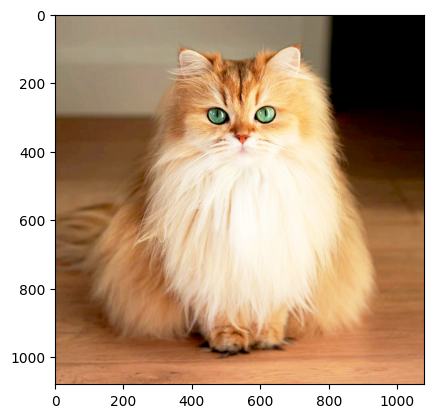

In [11]:
image = cv2.imread('cat.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

## 1. Một số phương pháp thường gặp

1.1. CropAndPad
- Cắt hoặc thêm pixel vào ảnh

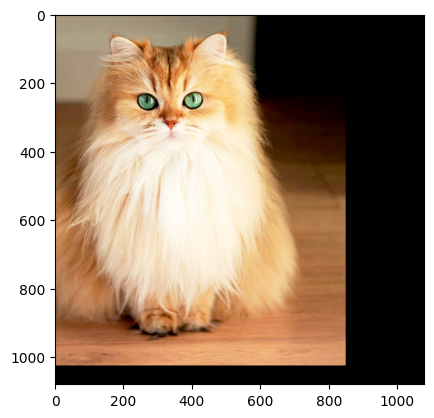

In [12]:
crop_and_pad = iaa.CropAndPad(percent = (-0.25, 0.25))

plt.imshow(cv2.cvtColor(crop_and_pad.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

1.2. Flip
- Flip left-right hoặc Flip up-down một số ảnh trong tập ảnh truyền vào

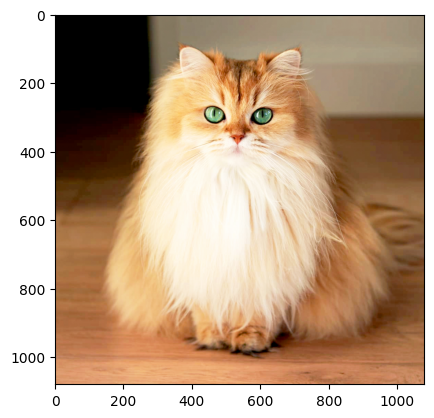

In [ ]:
# Flip left-right sử dụng hàm Fliplr với tham số 1.0
flip_lr = iaa.Fliplr(1.0)

plt.imshow(cv2.cvtColor(flip_lr.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

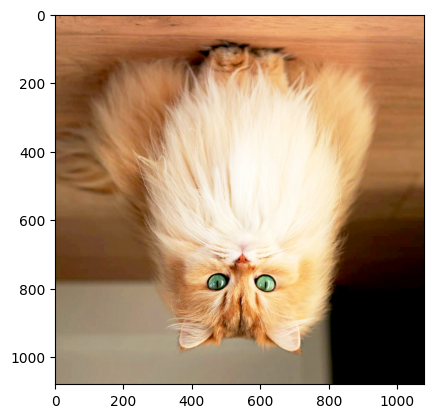

In [14]:
# Flip up-down sử dụng hàm Flipud với tham số 1.0
flip_ud = iaa.Flipud(1.0)

plt.imshow(cv2.cvtColor(flip_ud.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

1.3. Affine
- Các phép biến đổi aﬀine như scale, rotate, translate

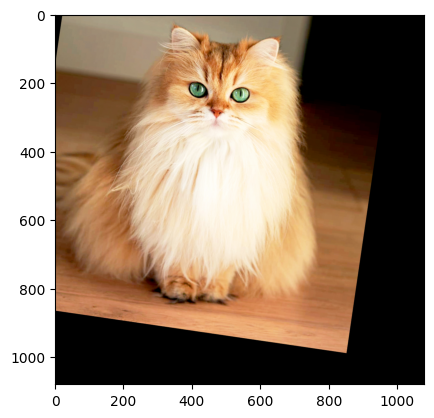

In [15]:
affine = iaa.Affine(scale = (0.5, 1.5), rotate = (-15, 15), translate_percent = (-0.2, 0.2))

plt.imshow(cv2.cvtColor(affine.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

1.4. Blur
- Sử dụng các bộ lọc Gaussian hoặc Mean

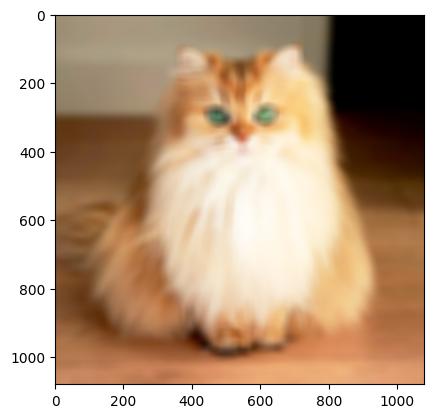

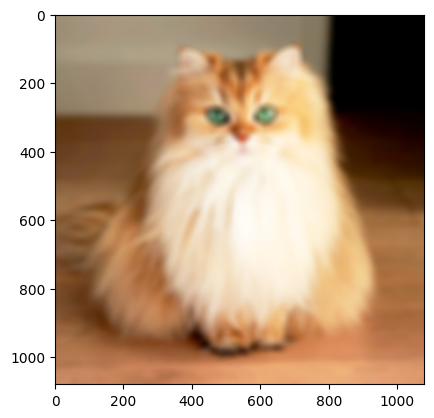

In [16]:
avg_blur = iaa.AverageBlur(k = (11, 31))
gauss_blur = iaa.GaussianBlur(sigma = (5.0, 15.0))

plt.imshow(cv2.cvtColor(avg_blur.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

plt.imshow(cv2.cvtColor(gauss_blur.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

1.5. Dropout
- Biến đổi ngẫu nhiên một phần ảnh thành các pixel đen

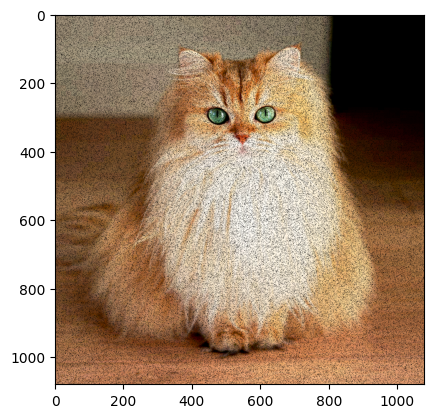

In [26]:
dropout = iaa.Dropout(p = (0, 0.2))

plt.imshow(cv2.cvtColor(dropout.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

## 2. Kết hợp nhiều Augmeneter

2.1. Sequential: Áp dụng các augmenter lần lượt theo thứ tự truyền vào

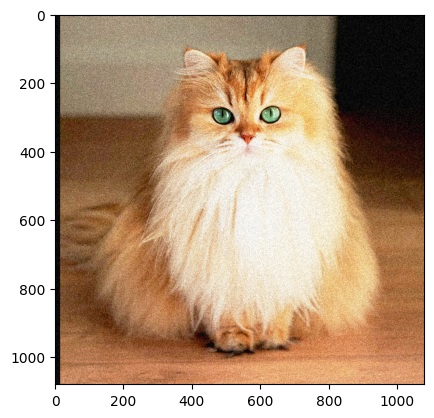

In [18]:
aug = iaa.Sequential([
    iaa.Affine(translate_px = {"x" : (-40, 40)}),
    iaa.AdditiveGaussianNoise(scale = 0.1 * 255)
])
plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

2.2. SomeOf: Áp dụng ngẫu nhiên một vài augmenter trong list các augmenter

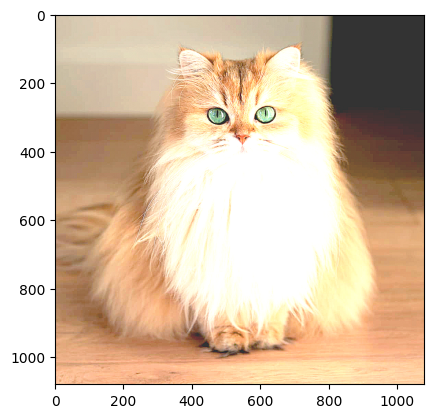

In [22]:
aug = iaa.SomeOf(2, [
    iaa.Affine(rotate = 45),
    iaa.AdditiveGaussianNoise(scale = 0.2 * 255),
    iaa.Add(50, per_channel = True),
    iaa.Sharpen(alpha = 0.5)
])
plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

2.3. Sometimes: Áp dụng augmenter với xác suất p

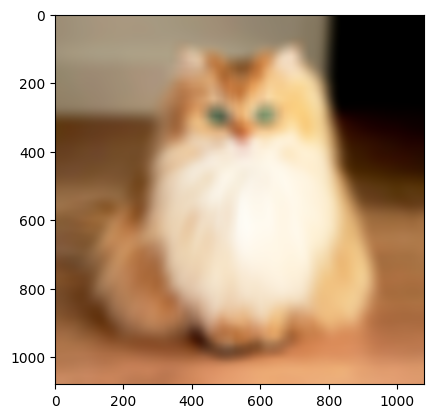

In [23]:
aug = iaa.Sometimes(0.5, iaa.GaussianBlur(sigma = 20.0))

plt.imshow(cv2.cvtColor(aug.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

## 3. Kết hợp cùng thư viện Keras

3.1. Bước 1: Khởi tạo Augmenter:

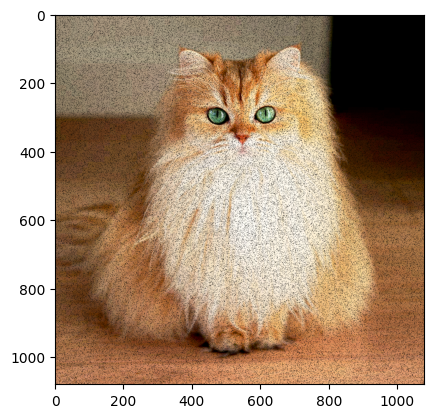

In [25]:
dropout_1 = iaa.Dropout(p = (0, 0.2))

plt.imshow(cv2.cvtColor(dropout.augment_image(image), cv2.COLOR_BGR2RGB))
plt.show()

3.2. Bước 2: Xây dựng generator

In [27]:
class Generator(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return self.images.shape[0]
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [ ]:
training_data = Generator(x_train, y_train)
train_dataloader = DataLoader(training_data, batch_size = 32, shuffle = True)

In [29]:
test_data = Generator(x_test, y_test)
test_dataloader = DataLoader(test_data, batch_size = 32, shuffle = True)

torch.Size([32, 28, 28])


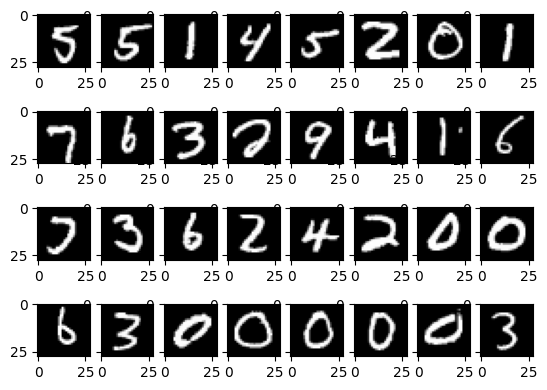

In [30]:
# Hiển thị một vài kết quả
for (batch_idx, target_tuple) in enumerate(train_dataloader):
    print(target_tuple[0].shape)
    for i in range(32):
        plt.subplot(4, 8, i + 1), plt.imshow(target_tuple[0][i], cmap = 'gray')
    plt.show()
    break

3.3. Bước 3: Train model với fit_generator

In [48]:
use_cuda = torch.cuda.is_available() #GPU cuda
best_loss = float('inf')
model = SimpleModel(dropout_rate = 0.5).to(device)
optimizer = torch.optim.Adadelta(model.parameters())
if use_cuda:
    model = torch.nn.parallel.DataParallel(modevicedel) # , device_ids=[0, 1, 2, 3]
    torch.backends.cudnn.benchmark = True

In [52]:
def train(epoch):
    print('\n ############################# Train phase, Epoch: {} #############################'.format(epoch))
    model.train()
    train_loss = 0

    print('\nLearning rate at this epoch is: ', optimizer.param_groups[0]['lr'], '\n')

    for (batch_idx, target_tuple) in enumerate(train_dataloader):
        if use_cuda:
            target_tuple = [target_tensor.cuda(non_blocking=True) for target_tensor in target_tuple]

        images, labels = target_tuple
        images = images.to(device)
        labels = labels.to(device).long()
        # Convert label to long type pytorch
        labels = torch.tensor(labels,dtype = torch.long)

        optimizer.zero_grad()  # zero the gradient buff
        output_tuple = model(images)

        loss = F.nll_loss(output_tuple, labels).to(device)

        loss.backward()  # retain_graph=True
        optimizer.step()

        train_loss += loss.item()  # loss　　　
        print('########################### Epoch:', epoch, ', --  batch:',  batch_idx, '/', len(train_dataloader), ',   ',
              'Train loss: %.3f, accumulated average loss: %.3f ##############################' % (loss.item(), train_loss / (batch_idx + 1)))

    global best_loss
    train_loss /= len(train_dataloader)
    if train_loss < best_loss:
      noti = 'best_'
      best_loss = train_loss
    else:
      noti = ''
    print('saving...')
    state = {
      'weights': model.state_dict(),
      'optimizer_weight': optimizer.state_dict(),
      'train_loss': train_loss,
      'epoch': epoch,
    }
    os.makedirs('checkpoints', exist_ok = True)
    torch.save(state, 'checkpoints/model_' + noti + str(epoch) + '_epoch.pth')



In [50]:
def test(epoch):
    print('\n ############################# Test phase, Epoch: {} #############################'.format(epoch))
    model.eval()
    with torch.no_grad():
        test_loss = 0

        for (batch_idx, target_tuple) in enumerate(test_dataloader):
            if use_cuda:
                target_tuple = [target_tensor.cuda(non_blocking=True) for target_tensor in target_tuple]

            images, labels = target_tuple
            images = images.to(device)
            labels = labels.to(device).long()
            # Convert label to long type pytorch
            labels = torch.tensor(labels,dtype=torch.long)
            output_tuple = model(images)

            loss = F.nll_loss(output_tuple, labels).to(device)

            test_loss += loss.item()  # loss　　　
            print('########################### Epoch:', epoch, ', --  batch:',  batch_idx, '/', len(test_dataloader), ',   ',
                  'Test loss: %.3f, accumulated average loss: %.3f ##############################' % (loss.item(), test_loss / (batch_idx + 1)))



In [53]:
no_epoch = 5
for epoch in range(no_epoch):
    train(epoch)
    test(epoch)


 ############################# Train phase, Epoch: 0 #############################

Learning rate at this epoch is:  1.0 

########################### Epoch: 0 , --  batch: 0 / 1875 ,    Train loss: 0.358, accumulated average loss: 0.358 ##############################
########################### Epoch: 0 , --  batch: 1 / 1875 ,    Train loss: 0.138, accumulated average loss: 0.248 ##############################
########################### Epoch: 0 , --  batch: 2 / 1875 ,    Train loss: 0.083, accumulated average loss: 0.193 ##############################
########################### Epoch: 0 , --  batch: 3 / 1875 ,    Train loss: 0.788, accumulated average loss: 0.342 ##############################
########################### Epoch: 0 , --  batch: 4 / 1875 ,    Train loss: 0.263, accumulated average loss: 0.326 ##############################
########################### Epoch: 0 , --  batch: 5 / 1875 ,    Train loss: 0.250, accumulated average loss: 0.313 ##############################
